In [1]:
import numpy as np
import glob

import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
X = []
Y = []

for i in glob.glob('data\\a\\*'): #windows \\
    image = cv2.imread(i)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray_image, (30,30), interpolation = cv2.INTER_AREA)
    X.append(resized.reshape(-1,))
    Y.append(0)
    
for i in glob.glob('data\\dA\\*'):
    image = cv2.imread(i)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray_image, (30,30), interpolation = cv2.INTER_AREA)
    X.append(resized.reshape(-1,))
    Y.append(1)
    
for i in glob.glob('data\\tA\\*'):
    image = cv2.imread(i)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray_image, (30,30), interpolation = cv2.INTER_AREA)
    X.append(resized.reshape(-1,))
    Y.append(2)
    
X = np.array(X)
X = (X)/255
Y = np.array(Y)
label_binarizer = LabelBinarizer()
Y = label_binarizer.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [3]:
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
K.set_image_dim_ordering('th')

In [4]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False)

X_train = X_train.reshape(-1,1,30,30).astype('float32')
datagen.fit(X_train.reshape(-1,1,30,30).astype('float32'))

In [5]:
x_aug = []
y_aug = []

i=0
for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=1000):
    x_aug.append(X_batch)
    y_aug.append(y_batch)
    i+=1
    if i>40:
        break
        
x_aug = np.array(x_aug).reshape(-1,30,30)
y_aug = np.array(y_aug).reshape(-1,3)

In [6]:
x_aug.shape

(8528, 30, 30)

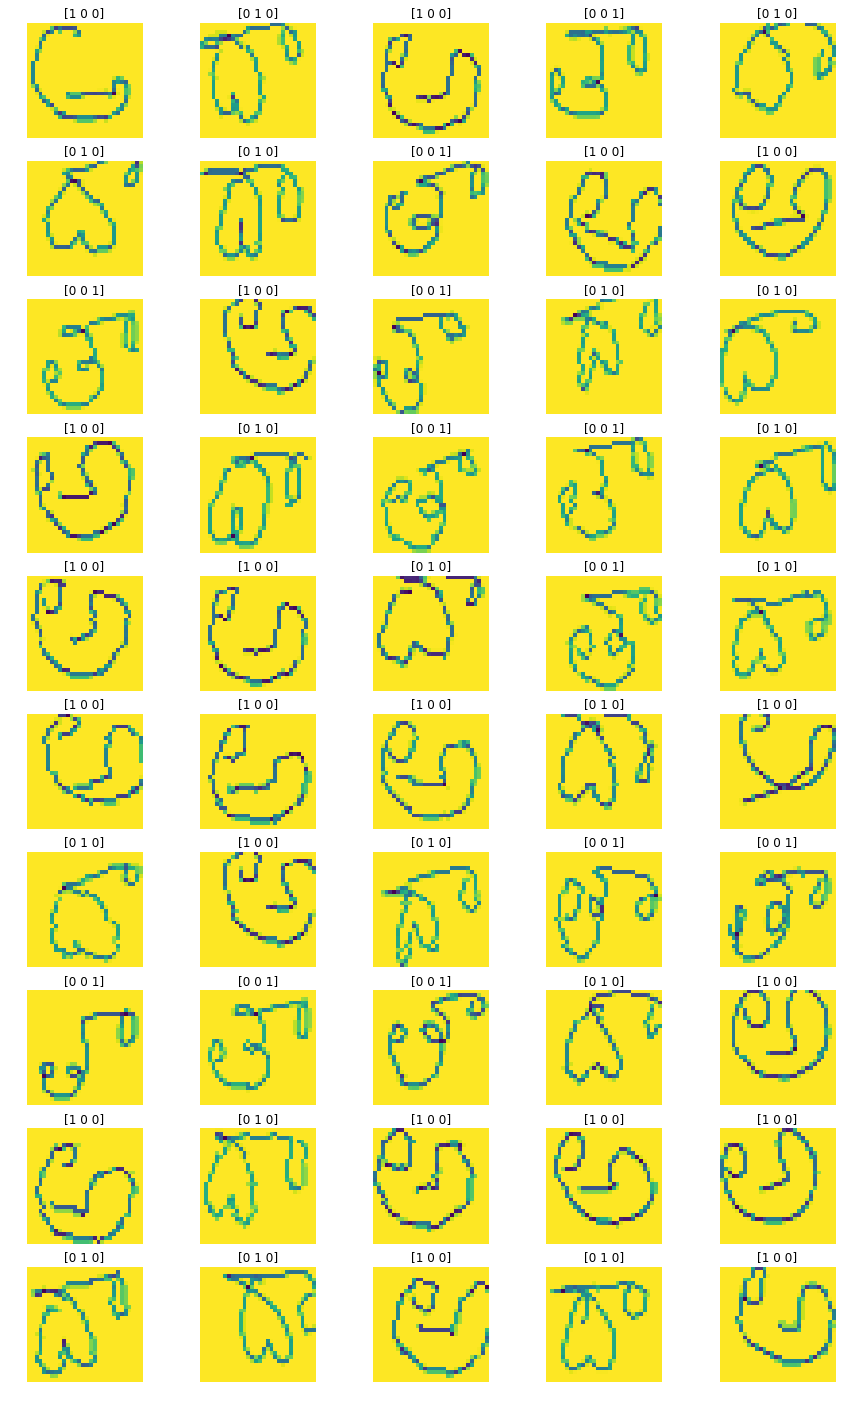

In [7]:
fig = plt.figure(figsize = (15,25))
for i in range(50):
    plt.subplot(10,5,i+1)
    index = np.random.randint(0,8000)
    plt.imshow(x_aug[index])
    plt.title(str(y_aug[index]))
    plt.axis('off')
plt.show()

In [8]:
x_aug = x_aug.reshape(-1,900)

In [9]:
class_count = [0,0,0]
for i in Y_test:
    if (i==[1,0,0]).all():
        class_count[0]+=1
    elif (i==[0,1,0]).all():
        class_count[1]+=1
    else:
        class_count[2]+=1
        
class_count

[28, 28, 34]

In [10]:
from sklearn.utils import shuffle
x_aug, y_aug = shuffle(x_aug, y_aug)

In [11]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(900,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               461312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 725,507
Trainable params: 725,507
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = 'adam', metrics=['accuracy'], loss='categorical_crossentropy')
history = model.fit(x_aug, y_aug, epochs=10, batch_size=16)

Epoch 1/10
8528/8528 [==============================] - 7s - loss: 0.5900 - acc: 0.9602     
Epoch 2/10
8528/8528 [==============================] - 7s - loss: 0.5754 - acc: 0.9758     
Epoch 3/10
8528/8528 [==============================] - 6s - loss: 0.5869 - acc: 0.9640     
Epoch 4/10
8528/8528 [==============================] - 6s - loss: 0.5925 - acc: 0.9585     
Epoch 5/10
8528/8528 [==============================] - 6s - loss: 0.5916 - acc: 0.9595     
Epoch 6/10
8528/8528 [==============================] - 6s - loss: 0.5873 - acc: 0.9640     
Epoch 7/10
8528/8528 [==============================] - 6s - loss: 0.5838 - acc: 0.9675     
Epoch 8/10
8528/8528 [==============================] - 6s - loss: 0.5886 - acc: 0.9626     
Epoch 9/10
8528/8528 [==============================] - 7s - loss: 0.5959 - acc: 0.9554     
Epoch 10/10
8528/8528 [==============================] - 6s - loss: 0.5839 - acc: 0.9675     


In [17]:
model.evaluate(X_test, Y_test)

32/90 [=========>....................] - ETA: 0s

[1.2403336630927191, 0.31111112303204008]

In [30]:
def unbin(y_aug):
    y_class = []
    for i in y_aug:
        if (i==[1,0,0]).all():
            y_class.append(1)
        elif (i==[0,1,0]).all():
            y_class.append(2)
        else:
            y_class.append(3)
    return np.array(y_class)

y_class = unbin(y_aug)

In [27]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', class_weight='balanced', C=2)
clf.fit(x_aug, y_class) 

SVC(C=2, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
clf.score(X_test, unbin(Y_test))

0.31111111111111112

#### Using SVM (extracted features)

In [4]:
X_ex = np.load("extracted_data/X.npy")
Y_ex = np.load("extracted_data/Y.npy")


X_train_ex, X_test_ex, Y_train_ex, Y_test_ex = train_test_split(X_ex, Y_ex, test_size=0.3)

In [5]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', class_weight='balanced', probability = True, C=1)
clf.fit(X_train_ex, Y_train_ex) 

clf.score(X_test_ex, Y_test_ex)

0.98888888888888893

#### ANN (extracted features)

In [16]:
Y_ex_hot = label_binarizer.fit_transform(Y_ex)
X_train_ex, X_test_ex, Y_train_ex_hot, Y_test_ex_hot = train_test_split(X_ex, Y_ex_hot, test_size=0.3)

model = Sequential()
model.add(Dense(50, input_shape=(1274,)))
#If activate need to be used adam with softmax and #sgd with relu -- (best)relu with adam (0.98)
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 50)                63750     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 153       
_________________________________________________________________
activation_7 (Activation)    (None, 3)                 0         
Total params: 63,903
Trainable params: 63,903
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer = 'sgd', metrics=['accuracy'], loss='categorical_crossentropy')  
history = model.fit(X_train_ex, Y_train_ex_hot, epochs=10, batch_size=1024)

Epoch 1/10
208/208 [==============================] - 0s - loss: 2.2560 - acc: 0.3173
Epoch 2/10
208/208 [==============================] - 0s - loss: 0.9534 - acc: 0.6154
Epoch 3/10
208/208 [==============================] - 0s - loss: 0.6568 - acc: 0.6971
Epoch 4/10
208/208 [==============================] - 0s - loss: 0.4626 - acc: 0.8510
Epoch 5/10
208/208 [==============================] - 0s - loss: 0.3704 - acc: 0.8942
Epoch 6/10
208/208 [==============================] - 0s - loss: 0.3101 - acc: 0.9183
Epoch 7/10
208/208 [==============================] - 0s - loss: 0.2734 - acc: 0.9423
Epoch 8/10
208/208 [==============================] - 0s - loss: 0.2478 - acc: 0.9471
Epoch 9/10
208/208 [==============================] - 0s - loss: 0.2284 - acc: 0.9519
Epoch 10/10
208/208 [==============================] - 0s - loss: 0.2127 - acc: 0.9519


In [63]:
model.evaluate(X_test_ex, Y_test_ex_hot)

32/90 [=========>....................] - ETA: 0s

[0.15047863953643376, 0.96666666666666667]